In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pylab as plt
import seaborn as sns
from sqlalchemy import create_engine
%matplotlib inline



## 2020-04-10 노출된 슈퍼업 상품들

In [2]:
data = pd.read_csv('20200410_superup.csv')
data = data[data['ctr'] < 1]

In [3]:
data['ctr'] = data['ctr']*100

In [4]:
data['ctr'].describe()

count    8094.000000
mean        2.820096
std         3.646162
min         0.000000
25%         0.000000
50%         2.300673
75%         4.000000
max        66.666667
Name: ctr, dtype: float64

In [206]:
data[(data['ctr'] < 3.5) & (data['view_cnt'] > 50)]

,content_id,imp_cnt,view_cnt,ctr
5,121349539,2214,73,3.297200
7,100693967,2874,94,3.270703
9,118466469,2155,62,2.877030
11,94840294,2641,86,3.256342
12,112249649,3141,79,2.515123
...,...,...,...,...
5825,121726635,2469,61,2.470636
5891,103784793,1944,64,3.292181
6053,121563122,1858,53,2.852530
6072,119950218,2162,58,2.682701


In [5]:
low = data[(data['ctr'] < 3.5) & (data['view_cnt'] > 50)]

In [6]:
high = data[(data['ctr'] > 5) & (data['view_cnt'] > 70)]

In [7]:
low_ids = ','.join('\''+str(i)+'\'' for i in low['content_id'].tolist())
high_ids = ','.join('\''+str(i)+'\'' for i in high['content_id'].tolist())

In [9]:
q = f'''
select 
  p.id as content_id, 
  p.category_id, 
  left(p.category_id, 3) as depth1, 
  p.name, 
  p.keyword, 
  p.price, 
  e.comment_cnt, 
  e.pfavcnt, 
  d.description,
  u.sex AS sex, 
  COALESCE(
    NULL, 
    CEIL(
      (
        EXTRACT(
          DAY 
          FROM 
            GETDATE()- u.birthdate :: timestamptz
        ) / 365.25
      )
    ), 
    0
  ) AS age_detail, 
  CASE WHEN age_detail < 20 THEN 10 WHEN age_detail >= 20 
  AND age_detail < 30 THEN 20 WHEN age_detail >= 30 
  AND age_detail < 40 THEN 30 ELSE 40 END AS age 
from 
  service1_quicket.product_info p 
  join service1_quicket.product_description d on d.pid = p.id
  join service1_quicket.product_ext e on p.id = e.pid 
  join service1_quicket.user_extra_info u on p.uid = u.uid 
where 
  p.id in ({low_ids}) and TO_DATE(u.birthdate, 'YYYY-MM-DD') > '1950-01-01'
'''
low_products_info = pd.read_sql(q,con=redshift)

In [12]:
low_products_info['content_id'] = low_products_info['content_id'].astype(str)
low['content_id'] = low['content_id'].astype(str)
low = pd.merge(low_products_info, low, on='content_id')

In [11]:
q = f'''
select 
  p.id as content_id, 
  p.category_id, 
  left(p.category_id, 3) as depth1, 
  p.name, 
  p.keyword, 
  p.price, 
  e.comment_cnt, 
  e.pfavcnt, 
  d.description,
  u.sex AS sex, 
  COALESCE(
    NULL, 
    CEIL(
      (
        EXTRACT(
          DAY 
          FROM 
            GETDATE()- u.birthdate :: timestamptz
        ) / 365.25
      )
    ), 
    0
  ) AS age_detail, 
  CASE WHEN age_detail < 20 THEN 10 WHEN age_detail >= 20 
  AND age_detail < 30 THEN 20 WHEN age_detail >= 30 
  AND age_detail < 40 THEN 30 ELSE 40 END AS age 
from 
  service1_quicket.product_info p 
  join service1_quicket.product_description d on d.pid = p.id
  join service1_quicket.product_ext e on p.id = e.pid 
  join service1_quicket.user_extra_info u on p.uid = u.uid 
where 
  p.id in ({high_ids}) and TO_DATE(u.birthdate, 'YYYY-MM-DD') > '1950-01-01'
'''
high_products_info = pd.read_sql(q,con=redshift)

In [13]:
high_products_info['content_id'] = high_products_info['content_id'].astype(str)
high['content_id'] = high['content_id'].astype(str)
high = pd.merge(high_products_info, high, on='content_id')

/Users/emilyPark/.pyenv/versions/3.7.5/envs/bun-analytics/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
low = low.sample(n=300)
high = high.sample(n=300)

### 카테고리

In [20]:
low.groupby('depth1',as_index=False)['content_id'].count().sort_values('content_id',ascending=False)

,depth1,content_id
3,320,117
7,600,61
4,400,41
2,310,28
9,750,27
8,700,7
12,910,5
0,200,4
10,800,4
5,410,2


In [21]:
high.groupby('depth1',as_index=False)['content_id'].count().sort_values('content_id',ascending=False)

,depth1,content_id
8,600,171
5,400,47
4,320,22
10,750,22
11,800,10
12,900,8
3,310,6
13,999,6
2,210,2
7,500,2


- 310(여성의류), 320(남성의류)가 노출량에 비해 ctr이 낮은 그룹에 속함  
- 600(디지털/가전) 이 ctr이 높음  


### 상품 제목

In [22]:
name_len = []
for i in low['name'].tolist():
    name_len.append(len(i))
low['name_len'] = name_len

name_len = []
for i in high['name'].tolist():
    name_len.append(len(i))
high['name_len'] = name_len

In [23]:
low[['name_len','ctr']].corr()

,name_len,ctr
name_len,1.00000,-0.07392
ctr,-0.07392,1.00000


In [24]:
high[['name_len', 'ctr']].corr()

,name_len,ctr
name_len,1.000000,-0.076192
ctr,-0.076192,1.000000


In [25]:
print(low['name_len'].describe())
print(high['name_len'].describe())

count    300.000000
mean      32.053333
std        9.114131
min        4.000000
25%       26.000000
50%       36.000000
75%       39.000000
max       40.000000
Name: name_len, dtype: float64
count    300.000000
mean      26.183333
std        9.733732
min        2.000000
25%       18.000000
50%       26.500000
75%       34.250000
max       48.000000
Name: name_len, dtype: float64


### 태그 갯수

In [26]:
num_tags = []
for i in low['keyword'].tolist():
    if i:
        num_tags.append(len(i.split(',')))
    else:
        num_tags.append(0)
low['num_tags'] = num_tags

num_tags = []
for i in high['keyword'].tolist():
    if i:
        num_tags.append(len(i.split(',')))
    else:
        num_tags.append(0)
high['num_tags'] = num_tags

In [27]:
low[['num_tags', 'ctr']].corr()

,num_tags,ctr
num_tags,1.000000,0.044601
ctr,0.044601,1.000000


In [28]:
high[['num_tags', 'ctr']].corr()

,num_tags,ctr
num_tags,1.000000,-0.121449
ctr,-0.121449,1.000000


In [29]:
print(low['num_tags'].describe())
print(high['num_tags'].describe())

count    300.000000
mean       4.820000
std        0.776494
min        0.000000
25%        5.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: num_tags, dtype: float64
count    300.000000
mean       4.346667
std        1.366032
min        0.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: num_tags, dtype: float64


### 상품 가격

In [30]:
low[['price', 'ctr']].corr()

,price,ctr
price,1.00000,-0.02353
ctr,-0.02353,1.00000


In [31]:
high[['price', 'ctr']].corr()

,price,ctr
price,1.000000,-0.105783
ctr,-0.105783,1.000000


In [32]:
print(low['price'].describe())
print(high['price'].describe())

count    3.000000e+02
mean     3.603092e+05
std      1.750462e+06
min      0.000000e+00
25%      2.197500e+04
50%      4.700000e+04
75%      1.121750e+05
max      2.350000e+07
Name: price, dtype: float64
count    3.000000e+02
mean     7.302659e+05
std      3.375931e+06
min      0.000000e+00
25%      4.500000e+04
50%      1.560000e+05
75%      4.075000e+05
max      4.790000e+07
Name: price, dtype: float64


In [33]:
print('avg. of low price :', low['price'].mean())
print('avg. of high price :', high['price'].mean())

avg. of low price : 360309.2
avg. of high price : 730265.94


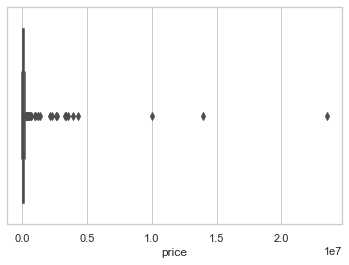

In [34]:
sns.set(style="whitegrid")
ax = sns.boxplot(x=low['price'])

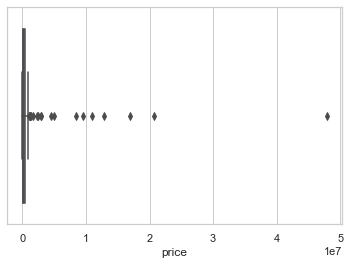

In [35]:
sns.set(style="whitegrid")
ax = sns.boxplot(x=high['price'])

### 댓글 수

In [36]:
low[['comment_cnt', 'ctr']].corr()

,comment_cnt,ctr
comment_cnt,1.000000,0.033898
ctr,0.033898,1.000000


In [37]:
high[['comment_cnt', 'ctr']].corr()

,comment_cnt,ctr
comment_cnt,1.000000,0.184682
ctr,0.184682,1.000000


In [38]:
low['comment_cnt'].describe()

count     300.000000
mean       35.306667
std       109.316052
min         0.000000
25%         4.000000
50%        10.000000
75%        24.000000
max      1167.000000
Name: comment_cnt, dtype: float64

In [39]:
high['comment_cnt'].describe()

count    300.000000
mean      38.463333
std       80.113644
min        0.000000
25%        5.000000
50%       15.000000
75%       36.250000
max      873.000000
Name: comment_cnt, dtype: float64

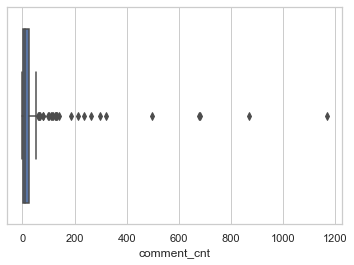

In [40]:
sns.set(style="whitegrid")
ax = sns.boxplot(x=low['comment_cnt'])

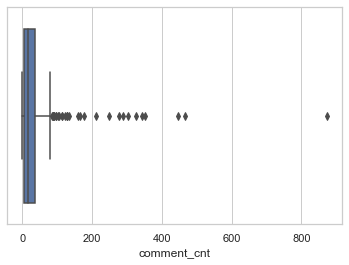

In [41]:
sns.set(style="whitegrid")
ax = sns.boxplot(x=high['comment_cnt'])

### 찜 수

In [42]:
low[['pfavcnt', 'ctr']].corr()

,pfavcnt,ctr
pfavcnt,1.000000,0.017633
ctr,0.017633,1.000000


In [43]:
high[['pfavcnt', 'ctr']].corr()

,pfavcnt,ctr
pfavcnt,1.000000,-0.009006
ctr,-0.009006,1.000000


In [44]:
low['pfavcnt'].describe()

count      300.000000
mean       350.740000
std        758.575208
min          1.000000
25%         53.000000
50%        150.000000
75%        390.000000
max      10094.000000
Name: pfavcnt, dtype: float64

In [45]:
high['pfavcnt'].describe()

count      300.000000
mean       477.560000
std       1094.064026
min          0.000000
25%         37.000000
50%        158.000000
75%        432.750000
max      12310.000000
Name: pfavcnt, dtype: float64

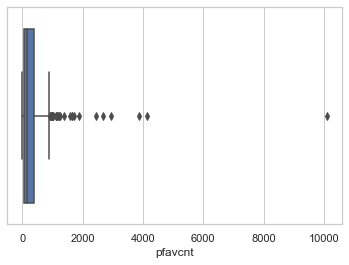

In [46]:
sns.set(style="whitegrid")
ax = sns.boxplot(x=low['pfavcnt'])

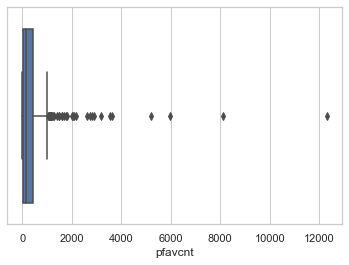

In [47]:
sns.set(style="whitegrid")
ax = sns.boxplot(x=high['pfavcnt'])

### 상품 설명 길이

In [48]:
description_len = []
for i in low['description'].tolist():
    if i:
        description_len.append(len(i))
    else:
        description_len.append(0)
low['description_len'] = description_len
        
description_len = []
for i in high['description'].tolist():
    if i:
        description_len.append(len(i))
    else:
        description_len.append(0)
high['description_len'] = description_len

In [49]:
low[['description_len', 'ctr']].corr()

,description_len,ctr
description_len,1.000000,0.012547
ctr,0.012547,1.000000


In [50]:
high[['description_len', 'ctr']].corr()

,description_len,ctr
description_len,1.000000,-0.023451
ctr,-0.023451,1.000000


In [51]:
low['description_len'].describe()

count     300.000000
mean      780.586667
std       511.646064
min         0.000000
25%       368.250000
50%       731.000000
75%       982.750000
max      1996.000000
Name: description_len, dtype: float64

In [52]:
high['description_len'].describe()

count     300.00000
mean      583.62000
std       468.62521
min         0.00000
25%       194.00000
50%       468.00000
75%       838.75000
max      1997.00000
Name: description_len, dtype: float64

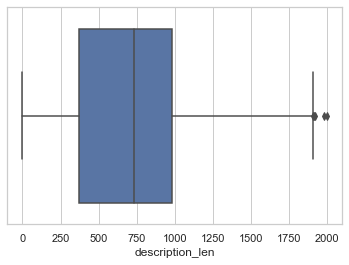

In [53]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.boxplot(x=low['description_len'])

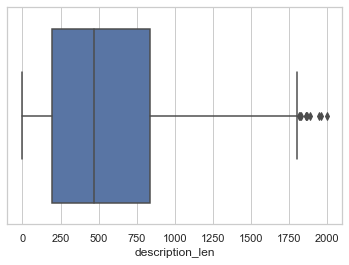

In [54]:
sns.set(style="whitegrid")
ax = sns.boxplot(x=high['description_len'])

### 성별
-- 0: normal / 1: Female / 2: Male

In [55]:
low.groupby('sex')['content_id'].count()

sex
0      2
1     59
2    239
Name: content_id, dtype: int64

In [56]:
high.groupby('sex')['content_id'].count()

sex
0      5
1     84
2    211
Name: content_id, dtype: int64

### 나이

In [57]:
low.groupby('age')['content_id'].count()

age
10      5
20    174
30     73
40     48
Name: content_id, dtype: int64

In [58]:
high.groupby('age')['content_id'].count()

age
10     11
20    179
30     63
40     47
Name: content_id, dtype: int64

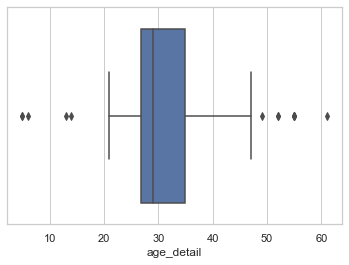

In [59]:
sns.set(style="whitegrid")
ax = sns.boxplot(x=low['age_detail'])

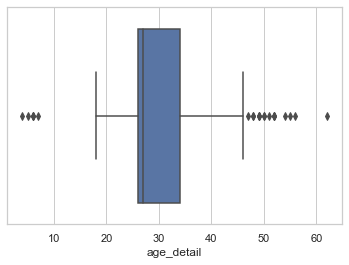

In [60]:
sns.set(style="whitegrid")
ax = sns.boxplot(x=high['age_detail'])

In [61]:
high[high['age_detail'] == high['age_detail'].max()]

,content_id,category_id,depth1,name,keyword,price,comment_cnt,pfavcnt,description,sex,age_detail,age,imp_cnt,view_cnt,ctr,name_len,num_tags,description_len
193,114818457,400051300,400,[정품]아디다스 알파바운스 슬라이드 슬리퍼,"아디다스,알파바운스,슬리퍼,adidas",36000,20,539,"지지대,택,박스 등 구성품 다 있습니다.\n당연히 정품입니다.\n택배거래시 +3,0...",1,62.0,40,738,83,11.246612,23,4,449
